# Sales Funnel Analysis 2
Let’s study the concept with the following example. First off, we’ll define the Sales Funnel and a set of conditions which will register as customer passing through each step of the Funnel.

* 0 step (necessary condition) – customer visits a site for the first time
* 1st step (awareness) – visits two site’s pages
* 2nd step (interest) – reviews a product page
* 3rd step (desire) –  adds a product to the shopping cart
* 4th step (action) – completes purchase

Second, we need to extract the data that includes sessions where corresponding events occurred. We’ll simulate this data with the following code:

In [17]:
# library(tidyverse)
# install.packages("purrrlyr")
library(purrrlyr)
library(dplyr)
library(reshape2)
library(ggplot2)

In [18]:
##### simulating the "real" data #####
set.seed(454)
df_raw <- data.frame(
    customer_id = paste0('id', sample(c(1:5000), replace = TRUE)), 
     date = as.POSIXct(rbeta(10000, 0.7, 10) * 10000000, origin = '2017-01-01', tz = "UTC"), 
     channel = paste0('channel_', sample(c(0:7), 10000, replace = TRUE, prob = c(0.2, 0.12, 0.03, 0.07, 0.15, 0.25, 0.1, 0.08))), 
     site_visit = 1) %>%
 
mutate(
    two_pages_visit = sample(c(0,1),10000,replace = TRUE,prob = c(0.8, 0.2)),
    product_page_visit = ifelse(two_pages_visit == 1,sample(c(0, 1),length(two_pages_visit[which(two_pages_visit == 1)]),replace = TRUE, prob = c(0.75, 0.25)),0),
    add_to_cart = ifelse(product_page_visit == 1,sample(c(0, 1),length(product_page_visit[which(product_page_visit == 1)]),replace = TRUE, prob = c(0.1, 0.9)),0),
    purchase = ifelse(add_to_cart == 1,sample(c(0, 1),length(add_to_cart[which(add_to_cart == 1)]),replace = TRUE, prob = c(0.02, 0.98)),0)) %>%
dmap_at(c('customer_id', 'channel'), as.character) %>%
arrange(date) %>%
mutate(session_id = row_number()) %>%
arrange(customer_id, session_id)

df_raw <- melt(
    df_raw, 
    id.vars = c('customer_id', 'date', 'channel', 'session_id'), 
    value.name = 'trigger', variable.name = 'event') %>%
filter(trigger == 1) %>%
select(-trigger) %>%
arrange(customer_id, date)

In [19]:
head(df_raw)

  customer_id                date   channel session_id              event
1         id1 2017-01-01 07:10:31 channel_0        841         site_visit
2         id1 2017-01-26 07:19:02 channel_0       9532         site_visit
3       id100 2017-01-01 04:24:38 channel_1        588         site_visit
4       id100 2017-01-02 12:07:43 channel_5       2542         site_visit
5       id100 2017-01-02 12:07:43 channel_5       2542    two_pages_visit
6       id100 2017-01-02 12:07:43 channel_5       2542 product_page_visit

Next up, the data needs to be preprocessed. For example, it would be useful to replace NA/direct channel with the previous one or separate first-time purchasers from current customers, or even create different Sales Funnels based on new and current customers, segments, locations and so on. I will omit this step but you can find some ideas on preprocessing in my previous blogpost.

The important thing about this approach is that we only have to attribute the initial marketing channel, one that led the customer through their first step. For instance, a customer initially reviews a product page (step 2, interest) and is brought by channel_1. That means any future product page visits from other channels won’t be attributed until the customer makes a purchase and starts a new Sales Funnel journey.

Therefore, we will filter records for each customer and save the first unique event of each step of the Sales Funnel using the following code:

In [20]:
### removing not first events ###
df_customers <- df_raw %>%
 group_by(customer_id, event) %>%
 filter(date == min(date)) %>%
 ungroup() %>% as.data.frame()

I point your attention that in this way we assume that all customers were first-time buyers, therefore every next purchase as an event will be removed with the above code.

Now, we can use the obtained data frame to compute Sales Funnel’s transition probabilities, importance of Sale Funnel steps, and their weighted importance. According to the method, the higher probability, the lower value of the channel. Therefore, we will calculate the importance of an each step as 1 minus transition probability. After that, we need to weight importances because their sum will be higher than 1. We will do these calculations with the following code:

In [21]:
### Sales Funnel probabilities ###
sf_probs <- df_customers %>%
  
 group_by(event) %>%
 summarise(customers_on_step = n()) %>%
 ungroup()

In [22]:
head(sf_probs)

,event,customers_on_step
1,site_visit,3130
2,two_pages_visit,1492
3,product_page_visit,437
4,add_to_cart,407
5,purchase,397


In [23]:
sf_probs <- sf_probs %>% 
mutate(
    sf_probs = round(customers_on_step / customers_on_step[event == 'site_visit'], 3),
    sf_probs_step = round(customers_on_step / lag(customers_on_step), 3),
    sf_probs_step = ifelse(is.na(sf_probs_step) == TRUE, 1, sf_probs_step),
    sf_importance = 1 - sf_probs_step,
    sf_importance_weighted = sf_importance / sum(sf_importance)
 )

In [24]:
head(sf_probs)

,event,customers_on_step,sf_probs,sf_probs_step,sf_importance,sf_importance_weighted
1,site_visit,3130,1,1,0,0
2,two_pages_visit,1492,0.477,0.477,0.523,0.395015105740181
3,product_page_visit,437,0.14,0.293,0.707,0.533987915407855
4,add_to_cart,407,0.13,0.931,0.069,0.0521148036253776
5,purchase,397,0.127,0.975,0.025,0.0188821752265861


A hint: it can be a good idea to compute Sales Funnel probabilities looking at a limited prior period, for example, 1-3 months. The reason is that customers’ flow or “necks” capacities could vary due to changes on a company’s site or due to changes in marketing campaigns and so on. Therefore, you can analyze the dynamics of the Sales Funnel’s transition probabilities in order to find the appropriate time period.

I can’t publish a blogpost without visualization. This time I suggest another approach for the Sales Funnel visualization that represents all customer journeys through the Sales Funnel with the following code:

In [25]:
head(df_customers)

  customer_id                date   channel session_id              event
1         id1 2017-01-01 07:10:31 channel_0        841         site_visit
2       id100 2017-01-01 04:24:38 channel_1        588         site_visit
3       id100 2017-01-02 12:07:43 channel_5       2542    two_pages_visit
4       id100 2017-01-02 12:07:43 channel_5       2542 product_page_visit
5       id100 2017-01-02 12:07:43 channel_5       2542        add_to_cart
6       id100 2017-01-02 12:07:43 channel_5       2542           purchase

In [26]:
### Sales Funnel visualization ###
df_customers_plot <- df_customers %>%
  
 group_by(event) %>%
 arrange(channel) %>%
 mutate(pl = row_number()) %>%
 ungroup() %>% as.data.frame()

head(df_customers_plot)

  customer_id                date   channel session_id           event pl
1         id1 2017-01-01 07:10:31 channel_0        841      site_visit  1
2      id1021 2017-01-01 01:51:41 channel_0        327      site_visit  2
3      id1021 2017-01-01 17:36:45 channel_0       1584 two_pages_visit  1
4      id1022 2017-01-07 11:02:09 channel_0       5949 two_pages_visit  2
5       id103 2017-01-20 07:30:19 channel_0       9042 two_pages_visit  3
6      id1038 2017-01-01 01:29:24 channel_0        282 two_pages_visit  4

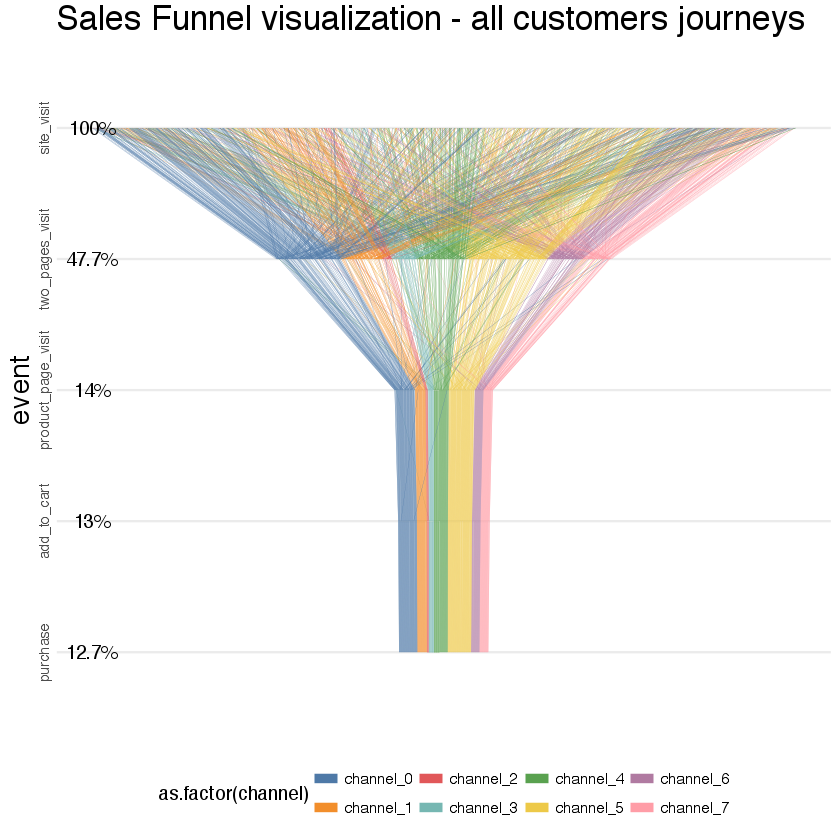

In [30]:
### Sales Funnel visualization ###
df_customers_plot <- df_customers %>%
  
 group_by(event) %>%
 arrange(channel) %>%
 mutate(pl = row_number()) %>%
 ungroup() %>%
  
 mutate(pl_new = case_when(
 event == 'two_pages_visit' ~ round((max(pl[event == 'site_visit']) - max(pl[event == 'two_pages_visit'])) / 2),
 event == 'product_page_visit' ~ round((max(pl[event == 'site_visit']) - max(pl[event == 'product_page_visit'])) / 2),
 event == 'add_to_cart' ~ round((max(pl[event == 'site_visit']) - max(pl[event == 'add_to_cart'])) / 2),
 event == 'purchase' ~ round((max(pl[event == 'site_visit']) - max(pl[event == 'purchase'])) / 2),
 TRUE ~ 0
 ),
 pl = pl + pl_new)
 
df_customers_plot$event <- factor(df_customers_plot$event, levels = c('purchase',
 'add_to_cart', 
 'product_page_visit',
 'two_pages_visit',
 'site_visit'
 ))
 
# color palette
cols <- c('#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
 '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac')
 
ggplot(df_customers_plot, aes(x = event, y = pl)) +
 theme_minimal() +
 scale_colour_manual(values = cols) +
 coord_flip() +
 geom_line(aes(group = customer_id, color = as.factor(channel)), size = 0.05) +
 geom_text(data = sf_probs, aes(x = event, y = 1, label = paste0(sf_probs*100, '%')), size = 4, fontface = 'bold') +
 guides(color = guide_legend(override.aes = list(size = 2))) +
 theme(legend.position = 'bottom',
 legend.direction = "horizontal",
 panel.grid.major.x = element_blank(),
 panel.grid.minor = element_blank(),
 plot.title = element_text(size = 20, face = "bold", vjust = 2, color = 'black', lineheight = 0.8),
 axis.title.y = element_text(size = 16, face = "bold"),
 axis.title.x = element_blank(),
 axis.text.x = element_blank(),
 axis.text.y = element_text(size = 8, angle = 90, hjust = 0.5, vjust = 0.5, face = "plain")) +
 ggtitle("Sales Funnel visualization - all customers journeys")